In [1]:
%load_ext autoreload
%autoreload 2
import os
import pickle as pkl
from os.path import join as oj

import dvu
import matplotlib as mpl
import matplotlib.pyplot as plt
from math import ceil
from tqdm import tqdm
import numpy as np
import matplotlib.patches as patches
import sys
sys.path.append('..')

mpl.rcParams['figure.dpi'] = 250
mpl.rcParams['axes.spines.top'] = False
mpl.rcParams['axes.spines.right'] = False

# change working directory to project root
if os.getcwd().split('/')[-1] == 'notebooks':
    os.chdir('../..')
from experiments.config.saps.datasets import DATASETS_CLASSIFICATION, DATASETS_REGRESSION
from experiments.viz import *
from experiments import viz

print('num_datasets', len(DATASETS_CLASSIFICATION), len(DATASETS_REGRESSION))

prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

/accounts/projects/vision/.local/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


num_datasets 11 9


In [ ]:
# run comparison aggregations
!python3 "../02_aggregate_comparisons.py"

# overarching plots

In [2]:
def make_comparison_grid(metric='rocauc', num_dsets=7, datasets=DATASETS_CLASSIFICATION,
                    models_to_include=['SAPS', 'CART'], save_name='fig'):
    R, C = ceil(num_dsets / 3), 3
    plt.figure(figsize=(3 * C, 2.5 * R), facecolor='w')
    
    COLORS = {
        'SAPS': 'black',
        'CART': 'orange', # cp,
        'Rulefit': 'green',
        'C45': cb,
        'CART_(MSE)': 'orange',
        'CART_(MAE)': cg,
        'SAPS_(Reweighted)': cg,
        'SAPS_(Include_Linear)': cb,
    }
    
    for i, dset in enumerate(tqdm(datasets[::-1][:num_dsets])):
        dset_name = dset[0]
#         try:
        ax = plt.subplot(R, C, i + 1)
        pkl_file = oj('../results', 'reg_data', dset_name, 'train-test/combined.pkl')
        df = pkl.load(open(pkl_file, 'rb'))['df']
        df['model'] = df.index
        for _, (name, g) in enumerate(df.groupby('model')):
            if name in models_to_include:
                x = g[f'{dset_name}_complexity']
                args = np.argsort(x)
#                 if i % C == C - 1:    
#                     for cutoff in args:
#                         if args[cutoff] >= 20:
#                             break
#                     args = args[:cutoff - 1]
                alpha = 1.0 if 'SAPS' == name else 0.35            
                lw = 2 if 'SAPS' == name else 1.5
                kwargs = dict(color=COLORS[name], alpha=alpha, lw=lw)            
#                 print(g.keys())
                plt.plot(x[args],
                         g[f'{dset_name}_{metric}_test'][args], '.-', **kwargs,
                         label=name.replace('_', ' ').replace('C45', 'C4.5'), zorder=-5)
    #             plt.plot(g[f'{dset_name}_complexity'][args], g[f'{dset_name}_{metric}_train'][args], '.--', **kwargs,
    #                      label=name + ' (Train)')
                plt.xlabel('Number of rules')
                plt.xlim((0, 20))
                plt.ylabel(dset_name.capitalize().replace('-', ' ') + ' ' + metric.upper().replace('ROC', '').replace('R2', '$R^2$'))
#         if i % C == C - 1:
        if i % C == C - 1:    
            rect = patches.Rectangle((18, 0), 100, 1, linewidth=1, edgecolor='w', facecolor='w', zorder=-4)
            dvu.line_legend(fontsize=10, xoffset_spacing=0.1, adjust_text_labels=True)
            ax.add_patch(rect)
#         except:
#             print('skipping', dset_name)
    viz.savefig(save_name)

100%|██████████| 6/6 [00:01<00:00,  3.46it/s]


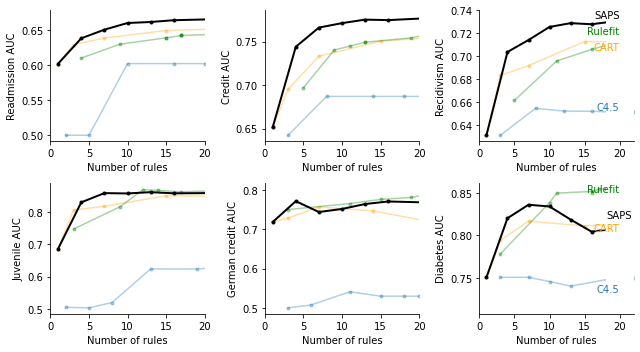

In [3]:
make_comparison_grid(metric='rocauc', num_dsets=6, datasets=DATASETS_CLASSIFICATION,
                models_to_include=['SAPS', 'CART', 'Rulefit', 'C45', 'CART_(MSE)', 'CART_(MAE)'],
                save_name='classification')

100%|██████████| 9/9 [00:02<00:00,  3.58it/s]


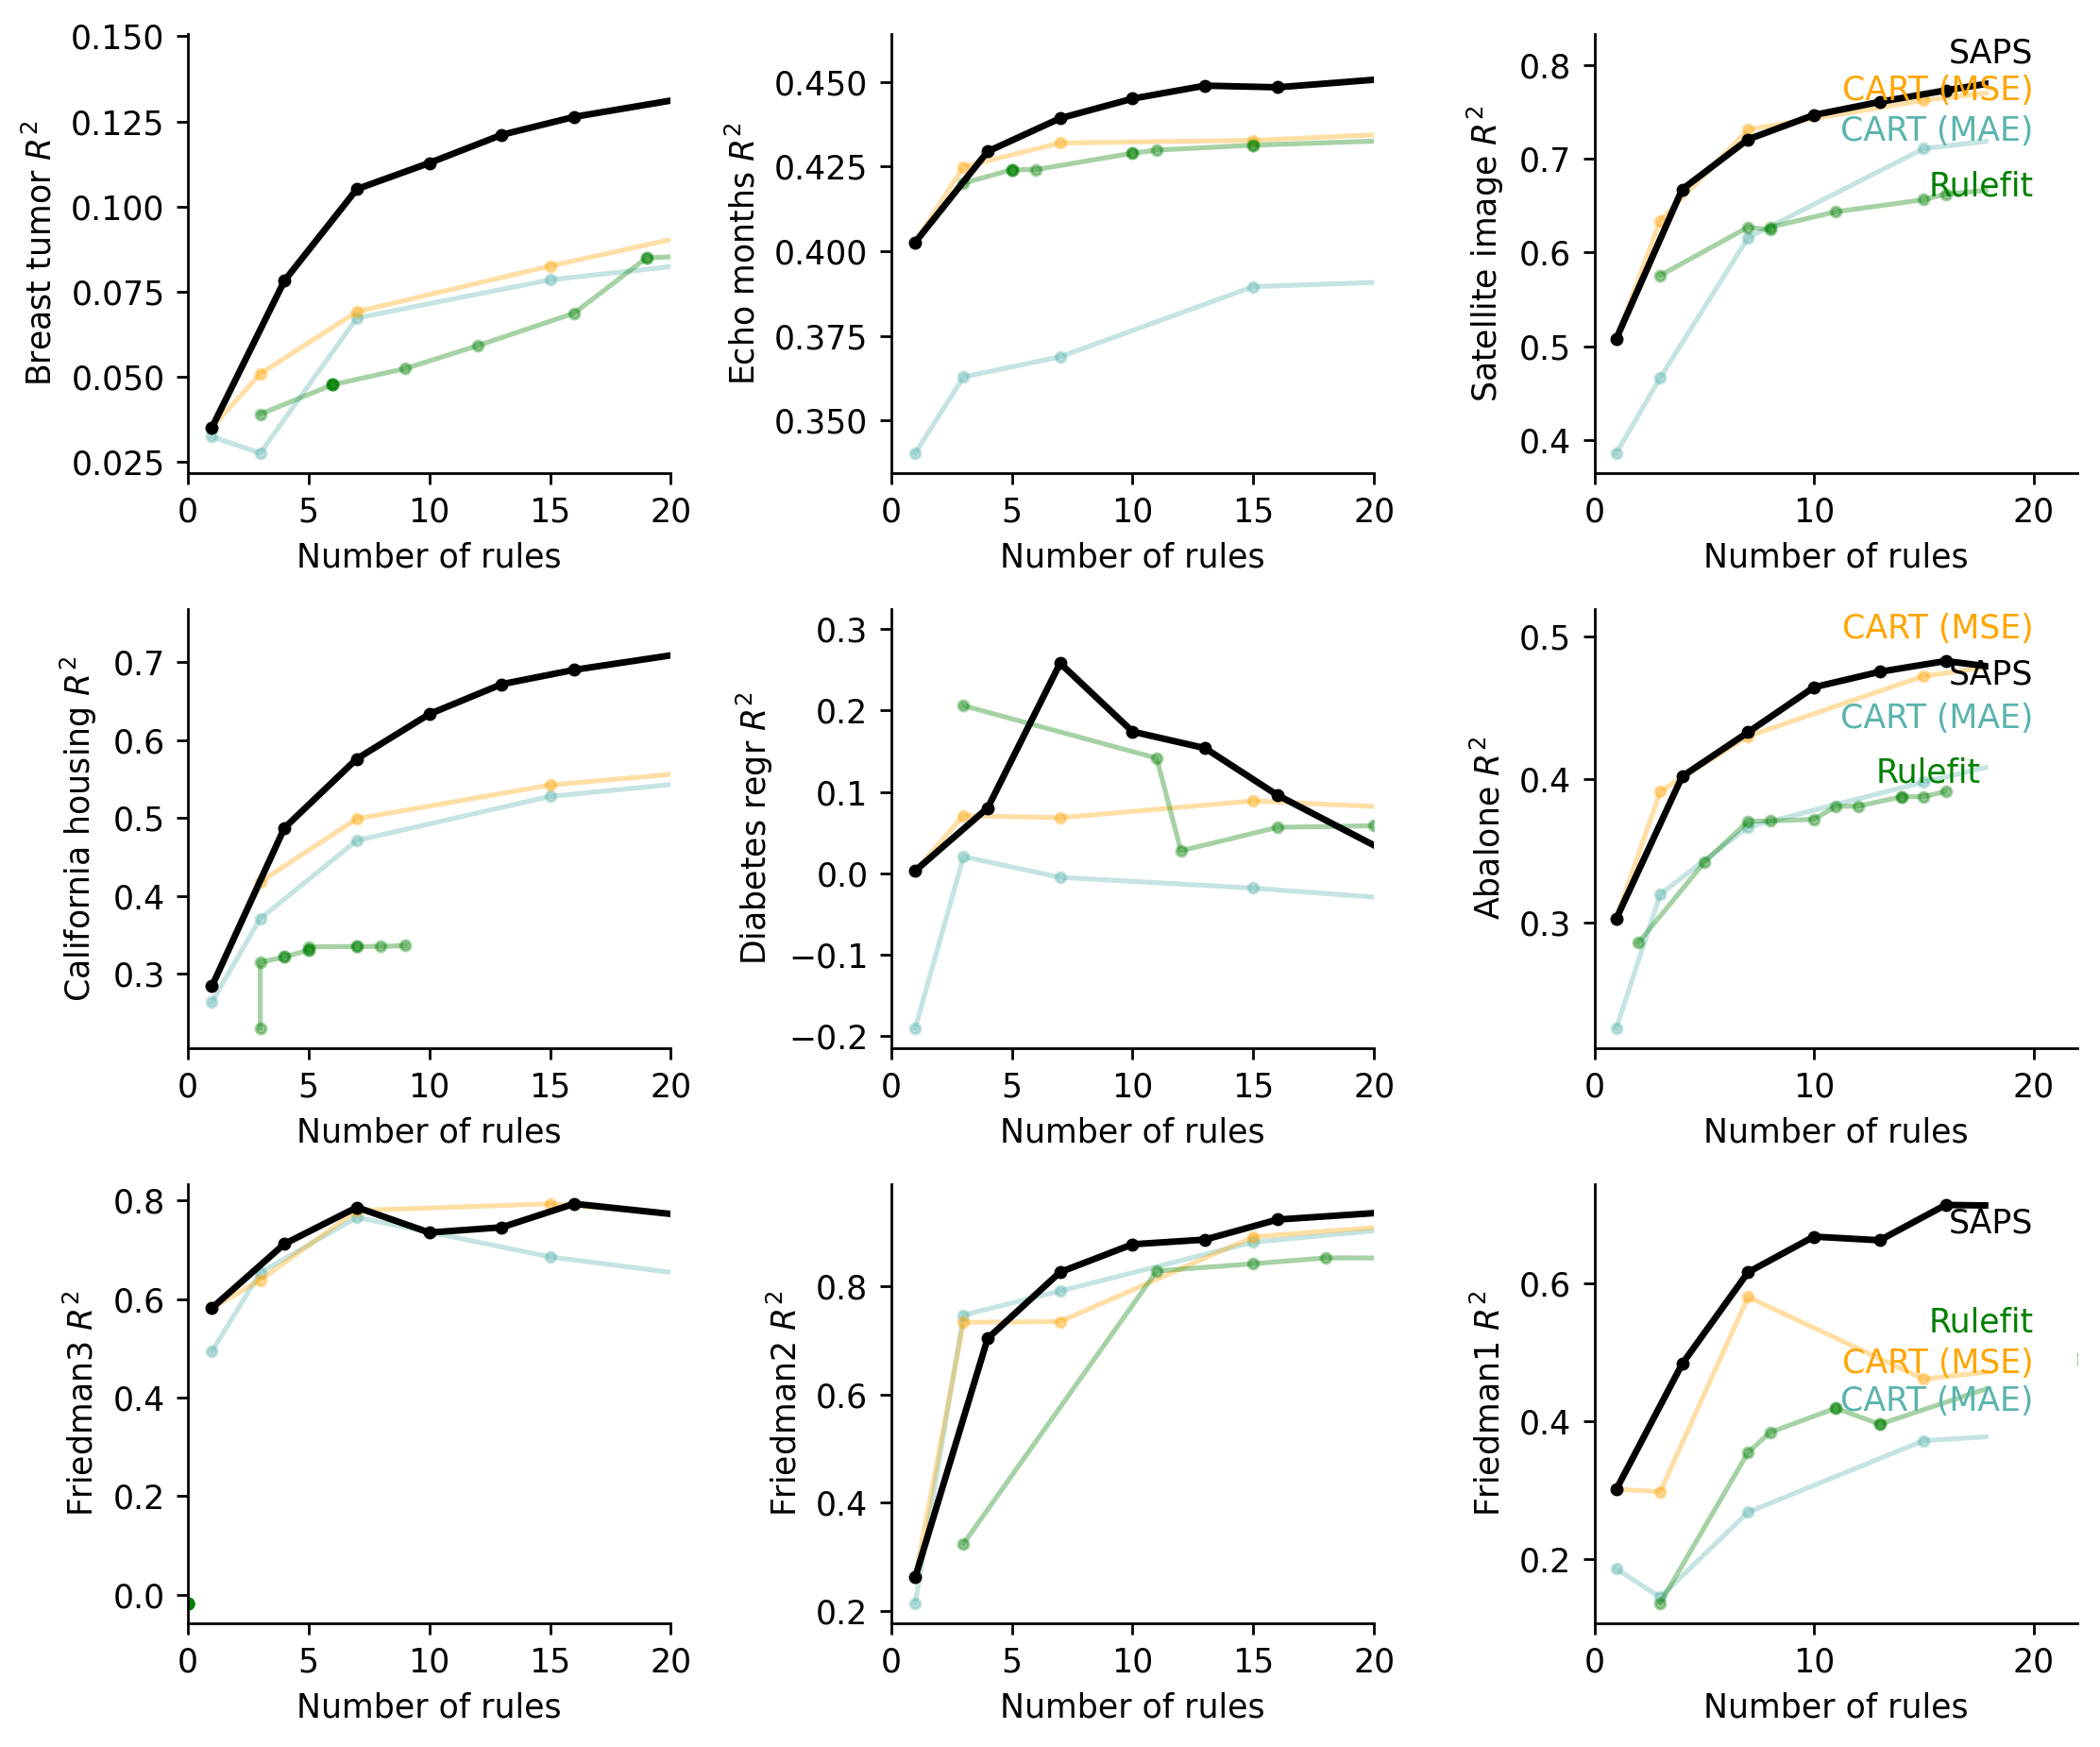

In [209]:
make_comparison_grid(metric='r2', num_dsets=9, datasets=DATASETS_REGRESSION,
                models_to_include=['SAPS', 'CART', 'Rulefit', 'C45', 'CART_(MSE)', 'CART_(MAE)'],
                save_name='regression') # neg_mean_squared_error, r2

In [ ]:
# make_comparison_grid(metric='rocauc', num_dsets=6, datasets=DATASETS_CLASSIFICATION,
#                 models_to_include=['SAPS', 'SAPS_(Include_Linear)', 'SAPS_(Reweighted)'],
#                 save_name='classification_variants') # neg_mean_squared_error, r2

In [ ]:
# make_comparison_grid(metric='r2', num_dsets=9, datasets=DATASETS_REGRESSION,
#                 models_to_include=['SAPS', 'SAPS_(Include_Linear)', 'SAPS_(Reweighted)'],
#                 save_name='regression_variants') # neg_mean_squared_error, r2

# classification

In [ ]:
metric = 'rocauc'
for dset in DATASETS_CLASSIFICATION:
    dset_name = dset[0]
    try:
        pkl_file = oj('../results', 'reg_data', dset_name, 'train-test/combined.pkl')
        df = pkl.load(open(pkl_file, 'rb'))['df']
        df['model'] = df.index

        #     print(list(df.keys()))
        plt.figure(figsize=(6, 4))
        #     R, C = 1, 2
        for i, (name, g) in enumerate(df.groupby('model')):
            args = np.argsort(g[f'{dset_name}_complexity'])
            plt.title(dset_name.capitalize())
            alpha = 1.0 if 'saps' in dset_name else 0.5            
            kwargs = dict(color=colors[i], alpha=alpha)            

            plt.plot(g[f'{dset_name}_complexity'][args], g[f'{dset_name}_{metric}_test'][args], '.-', **kwargs,
                     label=name + ' (Test)')
#             plt.plot(g[f'{dset_name}_complexity'][args], g[f'{dset_name}_{metric}_train'][args], '.--', **kwargs,
#                      label=name + ' (Train)')
            plt.xlabel('Complexity (basically number of rules)')
            plt.xlim((0, 25))
            plt.ylabel('AUC')
            dvu.line_legend(fontsize=10, xoffset_spacing=0.05, adjust_text_labels=False)
        plt.show()
    except:
        print('skipping', dset_name)

# regression

In [55]:
df.keys()

Index(['max_rules', 'friedman1_r2_train', 'friedman1_explained_variance_train',
       'friedman1_neg_mean_squared_error_train', 'friedman1_r2_test',
       'friedman1_explained_variance_test',
       'friedman1_neg_mean_squared_error_test', 'friedman1_complexity',
       'friedman1_time', 'mean_r2', 'mean_explained_variance',
       'mean_neg_mean_squared_error', 'mean_complexity', 'mean_time',
       'max_depth', 'posthoc_ridge', 'include_linear', 'n_estimators',
       'model'],
      dtype='object')

In [ ]:
metric = 'mse'
for dset in DATASETS_REGRESSION:
    dset_name = dset[0]
    pkl_file = oj('../results', 'reg_data', dset_name, 'train-test/combined.pkl')
    df = pkl.load(open(pkl_file, 'rb'))['df']
    df['model'] = df.index

    plt.figure(figsize=(6, 4))
    #     R, C = 1, 2
    for i, (name, g) in enumerate(df.groupby('model')):
        args = np.argsort(g[f'{dset_name}_complexity'])
        plt.title(dset_name.capitalize())
        kwargs = dict(color=colors[i])
        plt.plot(g[f'{dset_name}_complexity'][args], g[f'{dset_name}_{metric}_test'][args], '.-', **kwargs,
                 label=name + ' (Test)')
#         plt.plot(g[f'{dset_name}_complexity'][args], g[f'{dset_name}_{metric}_train'][args], '.--', **kwargs,
#                  label=name + ' (Train)')
        plt.xlabel('Complexity (basically number of rules)')
        #         plt.xlim((0, 25))
        plt.ylabel('R2')
        dvu.line_legend(fontsize=10, xoffset_spacing=0.05, adjust_text_labels=False)